In [1]:
# import library
from pathlib import Path
import math
import time
from collections import Counter
from tqdm import tqdm
import torch
from torch.utils.data import random_split
import torch.nn as nn
from torch import Tensor
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader
import torch.nn.functional as F
from torch import Tensor
import joblib
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
import umap
import seaborn as sns
import pandas as pd
import japanize_matplotlib

In [2]:
version = '06-2'
model_dir = './model/' + version
data_path = f'data/eq05-2.txt'
test_data_path = f'data/eq05-2-test.txt'



## 初期設定

### データセット定義

In [3]:

# 事前設定
%load_ext autoreload
%autoreload 2
torch.set_printoptions(linewidth=100)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

model_dir_path = Path(model_dir)

def read_file(file_path):
    with open(file_path, 'r') as file:
        lines = file.readlines()
    src_data, tgt_data = [], []
    for line in lines:
        src, tgt = line.strip().split(' => ')
        src_data.append(src)
        tgt_data.append(tgt)
    return src_data, tgt_data
SPECIALS = ['<start>', '<end>', '<pad>', '<unk>']

def build_vocab(texts):
    vocab = {}
    idx = 0
    # 数字の語彙定義
    for i in range(10):
        vocab[str(i)] = idx
        idx += 1
    # その他の文字の語彙定義
    for text in texts:
        for char in text:
            if char not in vocab:
                vocab[char] = idx
                idx += 1
    # 特別語の語彙定義
    for sp in SPECIALS:
        vocab[sp] = idx
        idx += 1
    return vocab


def convert_text_to_indexes(text, vocab):
    # <start> と <end> トークンを追加して数値化
    return [vocab['<start>']] + [vocab[char] if char in vocab else vocab['<unk>'] for char in text] + [vocab['<end>']]

# データを処理して Train と Valid に分ける関数
# データを処理して Train と Valid に分ける関数
def data_process_split(src_texts, tgt_texts, vocab_src, vocab_tgt, valid_size=0.2):
    # データを数値化
    data = []
    for (src, tgt) in zip(src_texts, tgt_texts):
        src_tensor = torch.tensor(convert_text_to_indexes(src, vocab_src), dtype=torch.long)
        tgt_tensor = torch.tensor(convert_text_to_indexes(tgt, vocab_tgt), dtype=torch.long)
        data.append((src_tensor, tgt_tensor))
    
    # データのサイズを計算して、訓練データと検証データに分割
    data_size = len(data)
    valid_size = int(valid_size * data_size)
    train_size = data_size - valid_size

    # PyTorchのrandom_splitを使って分割
    train_data, valid_data = random_split(data, [train_size, valid_size])
    
    return train_data, valid_data



Using device: cuda:0


In [4]:
src_data, tgt_data = read_file(data_path)
vocab_src = vocab_tgt = build_vocab(src_data + tgt_data)
reverse_vocab = {idx: token for token, idx in vocab_tgt.items()}

PAD_IDX = vocab_src['<pad>']
START_IDX = vocab_src['<start>']
END_IDX = vocab_src['<end>']

### モデル定義

In [5]:

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')


In [6]:
class TokenEmbedding(nn.Module):
    
    def __init__(self, vocab_size, embedding_size):
        
        super(TokenEmbedding, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_size, padding_idx=PAD_IDX)
        self.embedding_size = embedding_size
        
    def forward(self, tokens: Tensor):
        return self.embedding(tokens.long()) * math.sqrt(self.embedding_size)
    
    
class PositionalEncoding(nn.Module):
    
    def __init__(self, embedding_size: int, dropout: float, maxlen: int = 5000):
        super(PositionalEncoding, self).__init__()
        
        den = torch.exp(-torch.arange(0, embedding_size, 2) * math.log(10000) / embedding_size)
        pos = torch.arange(0, maxlen).reshape(maxlen, 1)
        embedding_pos = torch.zeros((maxlen, embedding_size))
        embedding_pos[:, 0::2] = torch.sin(pos * den)
        embedding_pos[:, 1::2] = torch.cos(pos * den)
        embedding_pos = embedding_pos.unsqueeze(-2)

        self.dropout = nn.Dropout(dropout)
        self.register_buffer('embedding_pos', embedding_pos)

    def forward(self, token_embedding: Tensor):
        return self.dropout(token_embedding + self.embedding_pos[: token_embedding.size(0), :])


class TransformerDecoderLayerScratch(nn.Module):
    def __init__(self, d_model, nhead, dim_feedforward, dropout=0.1):
        super(TransformerDecoderLayerScratch, self).__init__()
        # Self-attention for the decoder
        self.self_attn = nn.MultiheadAttention(d_model, nhead, dropout=dropout)
        # Multihead attention for attending to encoder outputs (memory)
        self.cross_attn = nn.MultiheadAttention(d_model, nhead, dropout=dropout)
        # Layer normalization layers
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        # Dropout
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)


    def forward(self, tgt, memory, tgt_mask=None, memory_mask=None, tgt_key_padding_mask=None, memory_key_padding_mask=None):
        # Self-attention
        tgt2, _ = self.self_attn(tgt, tgt, tgt, attn_mask=tgt_mask, key_padding_mask=tgt_key_padding_mask)
        tgt = tgt + self.dropout1(tgt2)
        tgt = self.norm1(tgt)
        
        #Cross-attention
        tgt2, _ = self.cross_attn(tgt, memory, memory, attn_mask=memory_mask, key_padding_mask=memory_key_padding_mask)
        tgt = tgt + self.dropout2(tgt2)
        tgt = self.norm2(tgt)

        return tgt

class TransformerEncoderLayerScratch(nn.Module):
    def __init__(self, d_model, nhead, dim_feedforward, dropout=0.1):
        super(TransformerEncoderLayerScratch, self).__init__()
        # Self-attention for the encoder
        self.self_attn = nn.MultiheadAttention(d_model, nhead, dropout=dropout)
        self.norm1 = nn.LayerNorm(d_model)
        self.dropout1 = nn.Dropout(dropout)

    def forward(self, src, src_mask=None, src_key_padding_mask=None):
        # Self-attention
        memory, _ = self.self_attn(src, src, src, attn_mask=src_mask, key_padding_mask=src_key_padding_mask)
        memory = src + self.dropout1(memory)
        memory = self.norm1(memory)
        
        return memory


class Seq2SeqTransformer(nn.Module):
    
    def __init__(
        self, num_encoder_layers: int, num_decoder_layers: int,
        embedding_size: int, vocab_size: int,
        dim_feedforward:int = 512, dropout:float = 0.1, nhead:int = 8
    ):
        
        super(Seq2SeqTransformer, self).__init__()

        self.token_embedding = TokenEmbedding(vocab_size, embedding_size)
        self.positional_encoding = PositionalEncoding(embedding_size, dropout=dropout)
        self.encoder_layer = TransformerEncoderLayerScratch(
            d_model=embedding_size, nhead=nhead, dim_feedforward=dim_feedforward, dropout=dropout
        )

        self.decoder_layer = TransformerDecoderLayerScratch(
            d_model=embedding_size, nhead=nhead, dim_feedforward=dim_feedforward, dropout=dropout
        )
        
        # self.output = nn.Linear(embedding_size, vocab_size)

    def forward(
        self, src: Tensor, tgt: Tensor,
        mask_src: Tensor, mask_tgt: Tensor,
        padding_mask_src: Tensor, padding_mask_tgt: Tensor,
        memory_key_padding_mask: Tensor
    ):
        embedding_src = self.positional_encoding(self.token_embedding(src))
        memory = self.encoder_layer(embedding_src, mask_src, padding_mask_src)
        embedding_tgt = self.positional_encoding(self.token_embedding(tgt))
        outs = self.decoder_layer(
            embedding_tgt, memory, mask_tgt, None,
            padding_mask_tgt, memory_key_padding_mask
        )
        return self.compute_output(outs)
    
    def compute_output(self, outs: Tensor):
        # token embeddingの重みを転置して出力層で使用する
        output = torch.matmul(outs/math.sqrt(self.token_embedding.embedding_size), self.token_embedding.embedding.weight.transpose(0, 1))
        return output

    def decode(self, tgt: Tensor, memory: Tensor, mask_tgt: Tensor):
        return self.decoder_layer(self.positional_encoding(self.token_embedding(tgt)), memory, mask_tgt)
    

def create_mask(src, tgt, PAD_IDX):
    
    seq_len_src = src.shape[0]
    seq_len_tgt = tgt.shape[0]

    mask_src = torch.zeros((seq_len_src, seq_len_src), device=device).type(torch.bool)
    mask_tgt = generate_square_subsequent_mask(seq_len_tgt)

    padding_mask_src = (src == PAD_IDX).transpose(0, 1)
    padding_mask_tgt = (tgt == PAD_IDX).transpose(0, 1)
    
    return mask_src, mask_tgt, padding_mask_src, padding_mask_tgt


def generate_square_subsequent_mask(seq_len):
    mask = (torch.triu(torch.ones((seq_len, seq_len), device=device)) == 1).transpose(0, 1)
    mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
    return mask

In [7]:


#loaded_model用のSeq2Seqクラス
class Seq2SeqForSavedModel(Seq2SeqTransformer):
    def __init__(self, *args, **kwargs):
        super(Seq2SeqForSavedModel, self).__init__(*args, **kwargs)
        self.pca = None

    def positional_encoding(self, tensor: Tensor, maxlen=5000):
        embedding_size = tensor.size(-1)
        den = torch.exp(-torch.arange(0, embedding_size, 2) * math.log(10000) / embedding_size)
        pos = torch.arange(0, maxlen).reshape(maxlen, 1)
        embedding_pos = torch.zeros((maxlen, embedding_size))
        embedding_pos[:, 0::2] = torch.sin(pos * den)
        embedding_pos[:, 1::2] = torch.cos(pos * den)
        embedding_pos = embedding_pos.unsqueeze(-2)
        return tensor + embedding_pos[: tensor.size(0), :].to(tensor.device)
    
    def self_attn_decoder(self, tgt, embedding_size):
        self_attn_wq, self_attn_wk, self_attn_wv = self.decoder_layer.self_attn.in_proj_weight.data.chunk(3, dim=0)
        self_attn_bq, self_attn_bk, self_attn_bv = self.decoder_layer.self_attn.in_proj_bias.data.chunk(3, dim=0)
        QW = torch.matmul(tgt.permute(1, 0, 2), self_attn_wq.T) + self_attn_bq
        KW = torch.matmul(tgt.permute(1, 0, 2), self_attn_wk.T) + self_attn_bk
        VW = torch.matmul(tgt.permute(1, 0, 2), self_attn_wv.T) + self_attn_bv
        self_attn_weights = F.softmax(torch.bmm(QW, KW.transpose(-2, -1)) / math.sqrt(embedding_size), dim=-1)
        AV = torch.matmul(self_attn_weights, VW)
        self_attn_output = torch.matmul(AV, self.decoder_layer.self_attn.out_proj.weight.data.T) + self.decoder_layer.self_attn.out_proj.bias.data
        return tgt + self_attn_output.permute(1, 0, 2), self_attn_output.permute(1, 0, 2), self_attn_weights

    def self_attn_encoder(self, tgt, embedding_size):
        self_attn_wq, self_attn_wk, self_attn_wv = self.encoder_layer.self_attn.in_proj_weight.data.chunk(3, dim=0)
        self_attn_bq, self_attn_bk, self_attn_bv = self.encoder_layer.self_attn.in_proj_bias.data.chunk(3, dim=0)
        QW = torch.matmul(tgt.permute(1, 0, 2), self_attn_wq.T) + self_attn_bq
        KW = torch.matmul(tgt.permute(1, 0, 2), self_attn_wk.T) + self_attn_bk
        VW = torch.matmul(tgt.permute(1, 0, 2), self_attn_wv.T) + self_attn_bv
        self_attn_weights = F.softmax(torch.bmm(QW, KW.transpose(-2, -1)) / math.sqrt(embedding_size), dim=-1)
        AV = torch.matmul(self_attn_weights, VW)
        self_attn_output = torch.matmul(AV, self.encoder_layer.self_attn.out_proj.weight.data.T) + self.encoder_layer.self_attn.out_proj.bias.data
        return tgt + self_attn_output.permute(1, 0, 2), self_attn_output.permute(1, 0, 2), self_attn_weights
    
    def cross_attn(self, tgt, memory, embedding_size):
        multi_attn_wq, multi_attn_wk, multi_attn_wv = self.decoder_layer.cross_attn.in_proj_weight.data.chunk(3, dim=0)
        multi_attn_bq, multi_attn_bk, multi_attn_bv = self.decoder_layer.cross_attn.in_proj_bias.data.chunk(3, dim=0)
        QW = torch.matmul(tgt.permute(1, 0, 2), multi_attn_wq.T) + multi_attn_bq
        KW = torch.matmul(memory.permute(1, 0, 2), multi_attn_wk.T) + multi_attn_bk
        VW = torch.matmul(memory.permute(1, 0, 2), multi_attn_wv.T) + multi_attn_bv
        multi_attn_weights = F.softmax(torch.bmm(QW, KW.transpose(-2, -1)) / math.sqrt(embedding_size), dim=-1)
        AV = torch.matmul(multi_attn_weights, VW)
        multi_attn_output = torch.matmul(AV, self.decoder_layer.cross_attn.out_proj.weight.data.T) + self.decoder_layer.cross_attn.out_proj.bias.data
        return tgt + multi_attn_output.permute(1, 0, 2), multi_attn_output.permute(1, 0, 2), multi_attn_weights

    def predict_next_token(self, src, tgt, embedding_size, device=device):
        memory = self.positional_encoding(self.token_embedding(src))
        tgt_embed = self.positional_encoding(self.token_embedding(tgt))
        tgt_mask = generate_square_subsequent_mask(tgt.size(0)).to(device).type(torch.bool)

        memory, _, _ = self.self_attn_encoder(memory, embedding_size)
        memory = self.encoder_layer.norm1(memory)
        # memory = self.encoder_layer.norm2(F.relu(self.encoder_layer.linear1(memory)) + memory)

        tgt, _, self_attn_weights = self.self_attn_decoder(tgt_embed, embedding_size)
        tgt = self.decoder_layer.norm1(tgt)
        tgt, _, multi_attn_weights = self.cross_attn(tgt, memory, embedding_size)
        tgt = self.decoder_layer.norm2(tgt)
        # tgt = self.decoder_layer.norm3(F.relu(self.decoder_layer.linear1(tgt)) + tgt)
        output = self.compute_output(tgt.transpose(0, 1)[:, -1])

        _, next_word = torch.max(output, dim=1)
        next_word = next_word.item()

        return next_word, self_attn_weights, multi_attn_weights
    


In [8]:
vocab_size_src = len(vocab_src)
vocab_size_tgt = len(vocab_tgt)
embedding_size = 4
nhead = 1
dim_feedforward = 4
num_encoder_layers = 1
num_decoder_layers = 1
dropout = 0
model_path = model_dir_path.joinpath(version + 'translation_transfomer.pth')

loaded_model = Seq2SeqForSavedModel(
    num_encoder_layers=num_encoder_layers,
    num_decoder_layers=num_decoder_layers,
    embedding_size=embedding_size,
    vocab_size=vocab_size_src,
    dim_feedforward=dim_feedforward,
    dropout=dropout, nhead=nhead
).to(device)
loaded_model.load_state_dict(torch.load(model_path))
loaded_model.eval()


Seq2SeqForSavedModel(
  (token_embedding): TokenEmbedding(
    (embedding): Embedding(14, 4, padding_idx=12)
  )
  (positional_encoding): PositionalEncoding(
    (dropout): Dropout(p=0, inplace=False)
  )
  (encoder_layer): TransformerEncoderLayerScratch(
    (self_attn): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=4, out_features=4, bias=True)
    )
    (norm1): LayerNorm((4,), eps=1e-05, elementwise_affine=True)
    (dropout1): Dropout(p=0, inplace=False)
  )
  (decoder_layer): TransformerDecoderLayerScratch(
    (self_attn): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=4, out_features=4, bias=True)
    )
    (cross_attn): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=4, out_features=4, bias=True)
    )
    (norm1): LayerNorm((4,), eps=1e-05, elementwise_affine=True)
    (norm2): LayerNorm((4,), eps=1e-05, elementwise_affine=True)
    (dropout1): Dropout(p=0, inplace=False)



## Attentionの図示

Attentionがうまく言っている例

In [9]:

def plot_heatmap(attention_map, src_label=[], ys_label=[], title="Attention Map"):
    # ヒートマップとしてAttentionを描画
    plt.figure(figsize=(8, 6))
    sns.heatmap(attention_map, annot=False, cmap='viridis', cbar=True)
    plt.title(title)
    xticks = [f"{src_label[i]}" for i in range(len(src_label))]
    yticks = [f"{ys_label[i]}" for i in range(len(ys_label))]
    plt.xticks(ticks=np.arange(len(src_label))+0.5, labels=xticks, rotation=0)
    plt.yticks(ticks=np.arange(len(ys_label))+0.5, labels=yticks, rotation=0)
    plt.xlabel("Source")
    plt.ylabel("Target")
    plt.show()

In [10]:
import random

# 最後の文字が0または1のデータをランダムに生成
def generate_random_data_last_digit_0_1(num_samples=100):
    zero_data = []
    one_data = []
    for _ in range(num_samples):
        # 最後の文字が0
        zero_number = ''.join(str(random.randint(0, 1)) for _ in range(4)) + '0'
        # 最後の文字が1
        one_number = ''.join(str(random.randint(0, 1)) for _ in range(4)) + '1'
        zero_data.append(zero_number)
        one_data.append(one_number)
    return zero_data, one_data

# ランダムなデータを生成
zero_data, one_data = generate_random_data_last_digit_0_1()

even_src = [torch.LongTensor(convert_text_to_indexes(text, vocab=vocab_src)).to(device) for text in zero_data]
odd_src = [torch.LongTensor(convert_text_to_indexes(text, vocab=vocab_src)).to(device) for text in one_data]

# 確認
print("Examples of random data ending with 0:", zero_data[:5])
print("Examples of random data ending with 1:", one_data[:5])

# 1個目の出力までを取得
text = zero_data[0]

# 翻訳処理を実行
tokens_src = convert_text_to_indexes(text, vocab=vocab_src)
src = torch.LongTensor(tokens_src).reshape(len(tokens_src), 1).to(device)
ys = torch.ones(1, 1).fill_(START_IDX).type(torch.long).to(device)

for _ in range(0):
    next_token, _, _ = loaded_model.predict_next_token(src, ys)
    ys = torch.cat([ys, torch.tensor([[next_token]], device=device)], dim=0)
print(ys)


Examples of random data ending with 0: ['01000', '00010', '11100', '00100', '11000']
Examples of random data ending with 1: ['10001', '00101', '11101', '11111', '10111']
tensor([[10]], device='cuda:0')


(7, 7)


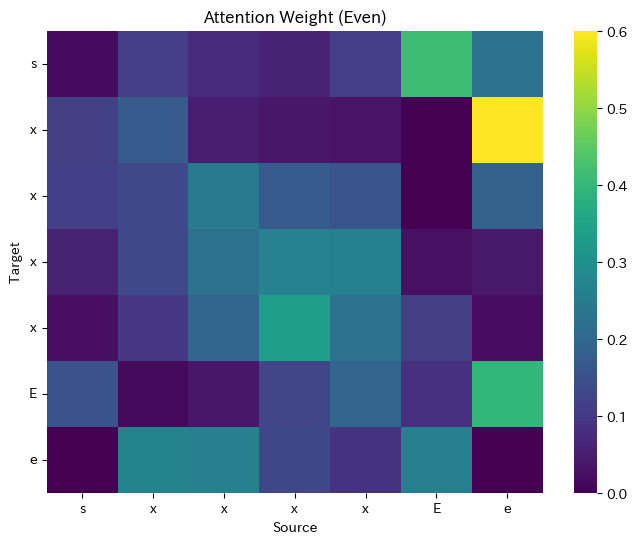

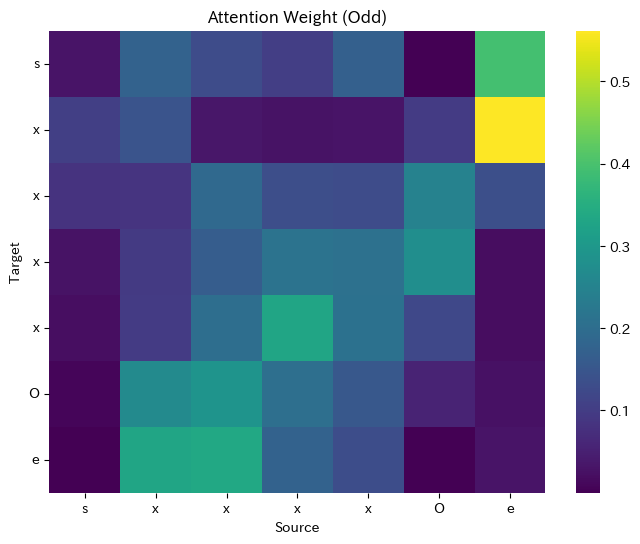

In [11]:
def extract_self_attention_vectors(data_src, model=loaded_model, embedding_size=embedding_size):
    attn_maps = []
    for src in data_src:
        src = src.view(-1, 1)  # Reshape to (seq_len, batch_size)
        memory = model.positional_encoding(model.token_embedding(src))
        _, _, attn_map = model.self_attn_encoder(memory, embedding_size)
        attn_maps.append(attn_map.detach().cpu().numpy())
    attn_maps = np.array(attn_maps)
    return attn_maps

# self-attentionのベクトルを抽出
even_vectors_sa = extract_self_attention_vectors(even_src, loaded_model).mean(axis=0).squeeze()
odd_vectors_sa = extract_self_attention_vectors(odd_src, loaded_model).mean(axis=0).squeeze()

# Cross AttentionのAttentionWeightのヒートマップを表示
print(even_vectors_sa.shape)
plot_heatmap(even_vectors_sa, title="Attention Weight (Even)", src_label="sxxxxEe", ys_label="sxxxxEe")
plot_heatmap(odd_vectors_sa, title="Attention Weight (Odd)", src_label="sxxxxOe", ys_label="sxxxxOe")

(100, 7) (100, 7)
(100, 7)


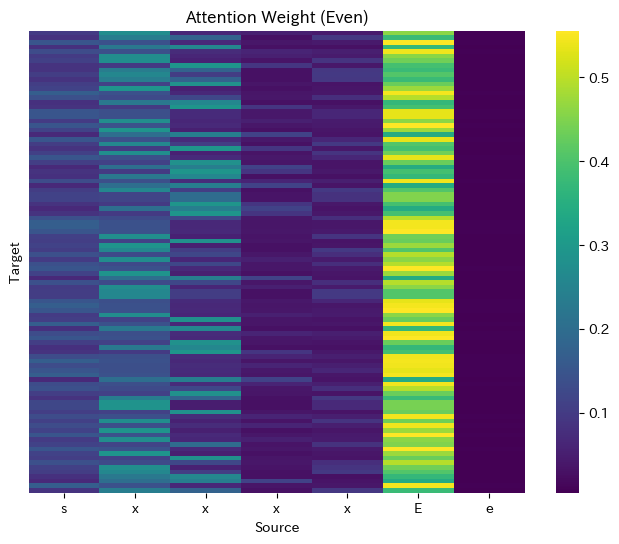

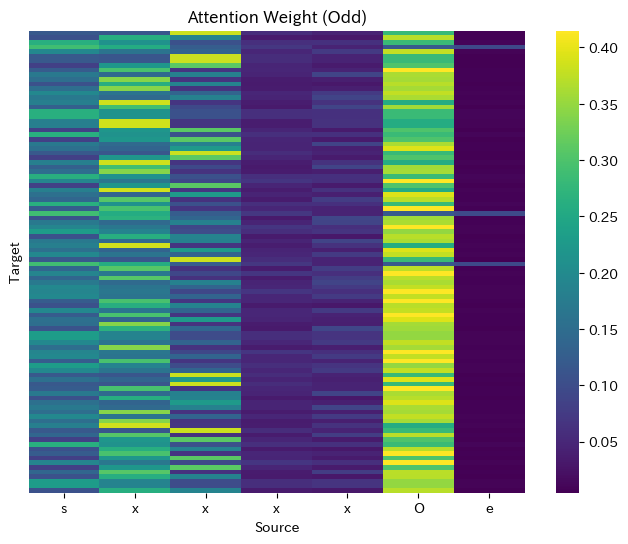

In [12]:

# Cross-AttentionのAttentionWeightの出力を取得
def extract_vectors(data_src, model=loaded_model, embedding_size=embedding_size):
    vectors = []
    for src in data_src:
        src = src.view(-1, 1)  # Reshape to (seq_len, batch_size)
        tgt = model.positional_encoding(model.token_embedding(ys))
        
        memory = model.positional_encoding(model.token_embedding(src))
        memory, _, _ = model.self_attn_encoder(memory, embedding_size)
        memory = model.encoder_layer.norm1(memory)

        tgt, _, _ = model.self_attn_decoder(tgt, embedding_size)
        tgt = model.decoder_layer.norm1(tgt)

        tgt, tgt_, attention_weight = model.cross_attn(tgt, memory, embedding_size)
        vectors.append(attention_weight.detach().cpu().numpy().squeeze())
    vectors_array = np.array(vectors)
    return vectors_array
    

# 偶数と奇数のCross Attention後のベクトルリストを取得
even_vectors_ca = extract_vectors(even_src, loaded_model)
odd_vectors_ca = extract_vectors(odd_src, loaded_model)
print(even_vectors_ca.shape, odd_vectors_ca.shape)# Cross AttentionのAttentionWeightのヒートマップを表示
print(even_vectors_ca.shape)
plot_heatmap(even_vectors_ca, title="Attention Weight (Even)", src_label="sxxxxEe")
plot_heatmap(odd_vectors_ca, title="Attention Weight (Odd)", src_label="sxxxxOe")

00010
[[8.5428290e-02 2.3473242e-01 1.7448899e-01 2.8636249e-02 9.3972042e-02
  3.7779877e-01 4.9432931e-03]
 [2.5196506e-02 1.5542774e-02 2.2708735e-01 3.7398371e-01 2.5727773e-01
  8.2352936e-02 1.8558972e-02]
 [1.3035161e-03 2.9611611e-04 1.2818826e-02 6.4181453e-01 6.4543545e-02
  5.7245500e-04 2.7865100e-01]
 [4.5097504e-02 2.5450760e-01 5.2557476e-02 7.6438189e-02 1.1559879e-01
  3.0179657e-02 4.2562079e-01]
 [1.6896008e-02 6.6686273e-01 3.2004663e-03 1.8066119e-03 8.0506224e-03
  4.7677755e-03 2.9841581e-01]
 [1.5608537e-04 9.9929798e-01 9.9726094e-08 7.2637146e-10 1.2942974e-07
  8.3991645e-06 5.3717580e-04]
 [8.0470556e-08 9.9818999e-01 5.8979065e-15 1.9341192e-17 5.9374936e-14
  6.2654148e-12 1.8099335e-03]]


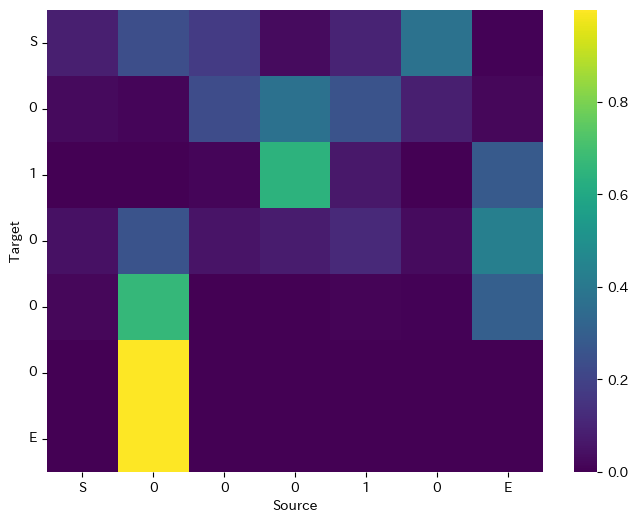

In [13]:
# 結果の出力を取得
def extract_vectors(data_src, nth_token, model=loaded_model, embedding_size=embedding_size):
    vectors = []
    for src in data_src:
        src = src.view(-1, 1)
        memory = model.positional_encoding(model.token_embedding(src))
        memory, _, _ = model.self_attn_encoder(memory, embedding_size)
        memory = model.encoder_layer.norm1(memory)
        
        tgt_tmp = ys
        for _ in range(nth_token):
            tgt_embed = model.positional_encoding(model.token_embedding(tgt_tmp))
            tgt, _, self_attn_weights = model.self_attn_decoder(tgt_embed, embedding_size)
            tgt = model.decoder_layer.norm1(tgt)
            tgt, _, multi_attn_weights = model.cross_attn(tgt, memory, embedding_size)
            tgt = model.decoder_layer.norm2(tgt)
            # tgt = self.decoder_layer.norm3(F.relu(self.decoder_layer.linear1(tgt)) + tgt)
            output = model.compute_output(tgt.transpose(0, 1)[:, -1])

            _, next_word = torch.max(output, dim=1)
            next_token = next_word.item()

            tgt_tmp = torch.cat([tgt_tmp, torch.tensor([[next_token]], device=device)], dim=0)

            attn_map = multi_attn_weights.detach().cpu().numpy()
            vectors.append(attn_map[:, -1, :])

    vectors_array = np.array(vectors)
    return vectors_array

tgt_index = 1
nth_token=7
print(zero_data[tgt_index])
test_vectors = extract_vectors([even_src[tgt_index]], nth_token, loaded_model).squeeze()
print(test_vectors)
plot_heatmap(test_vectors[:, :], "S"+zero_data[tgt_index]+"E", "S"+zero_data[tgt_index][::-1]+"E", title="")

['10100', '10111', '10101', '11000', '11101', '11111', '00110', '11001', '10110', '01001', '11110', '01110', '00001', '01111', '10000', '11011', '01011', '10011', '01000', '10010', '01010', '00011', '01101', '11010', '11100', '00101', '00010', '00000', '00111', '01100', '10001', '00100']
00010
(7, 7)


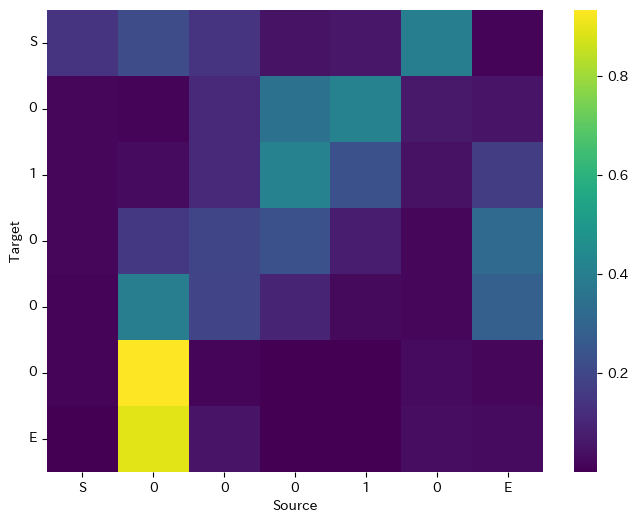

In [14]:
# 結果の出力を取得
def extract_vectors(data_src, nth_token, model=loaded_model, embedding_size=embedding_size):
    vectors = []
    for src in data_src:
        src = src.view(-1, 1)
        memory = model.positional_encoding(model.token_embedding(src))
        memory, _, _ = model.self_attn_encoder(memory, embedding_size)
        memory = model.encoder_layer.norm1(memory)
        
        tgt_tmp = ys
        vectors_ = []
        for _ in range(nth_token):
            tgt_embed = model.positional_encoding(model.token_embedding(tgt_tmp))
            tgt, _, self_attn_weights = model.self_attn_decoder(tgt_embed, embedding_size)
            tgt = model.decoder_layer.norm1(tgt)
            tgt, _, multi_attn_weights = model.cross_attn(tgt, memory, embedding_size)
            tgt = model.decoder_layer.norm2(tgt)
            # tgt = self.decoder_layer.norm3(F.relu(self.decoder_layer.linear1(tgt)) + tgt)
            output = model.compute_output(tgt.transpose(0, 1)[:, -1])

            _, next_word = torch.max(output, dim=1)
            next_token = next_word.item()

            tgt_tmp = torch.cat([tgt_tmp, torch.tensor([[next_token]], device=device)], dim=0)

            attn_map = multi_attn_weights.detach().cpu().numpy()
            vectors_.append(attn_map[:, -1, :])
        vectors.append(vectors_)
    vectors_array = np.array(vectors)
    return vectors_array

all_data = []
for i1 in range(2):
    for i2 in range(2):
        for i3 in range(2):
            for i4 in range(2):
                for i5 in range(2):
                    all_data.append(str(i1)+str(i2)+str(i3)+str(i4)+str(i5))
all_data = list(set(all_data))
print(all_data)

all_src = [torch.LongTensor(convert_text_to_indexes(text, vocab=vocab_src)).to(device) for text in all_data]

nth_token=7
print(zero_data[tgt_index])
test_vectors = extract_vectors(all_src, nth_token, loaded_model).squeeze().mean(axis=0)
print(test_vectors.shape)
plot_heatmap(test_vectors, "S"+zero_data[tgt_index]+"E", "S"+zero_data[tgt_index][::-1]+"E", title="")

# 各層の出力の可視化

## 初期設定

In [59]:

def plot_stripplot(zero_output, one_output):
    zero_df = pd.DataFrame(zero_output, columns=[reverse_vocab[i] for i in range(0, len(zero_output[0]))])
    zero_df['type'] = 'zero'
    one_df = pd.DataFrame(one_output, columns=[reverse_vocab[i] for i in range(0, len(one_output[0]))])
    one_df['type'] = 'one'
    df = pd.concat([zero_df, one_df])
    df = df.melt(id_vars='type', var_name='token', value_name='probability')

    plt.figure(figsize=(10, 5))
    sns.stripplot(data=df, x='token', y='probability', hue='type', jitter=0.2, dodge=True)
    plt.title("Output Probability")
    plt.xlabel("Token")
    plt.ylabel("Probability")
    plt.legend(title="Correct Answer")
    plt.show()

def plot_pca_zero_one(zero_vectors, one_vectors, model=loaded_model, withEnv=True, label1="zero", label2="one", title=""):
    all_vectors = np.vstack((zero_vectors, one_vectors))
    pca = PCA(n_components=2)
    src = torch.LongTensor(list(vocab_src.values())).to(device)
    token_embedding = model.token_embedding(src).detach().cpu().numpy()
    pca.fit(token_embedding)
    reduced_vectors = pca.transform(all_vectors)
    reduced_embedding = pca.transform(token_embedding)
    plt.figure(figsize=(10, 7))
    # 偶数データをプロット
    plt.scatter(
        reduced_vectors[:len(zero_vectors), 0],  # 偶数のx座標
        reduced_vectors[:len(zero_vectors), 1],  # 偶数のy座標
        alpha=0.5, label=label1, color='blue'
    )
    # 奇数データをプロット
    plt.scatter(
        reduced_vectors[len(zero_vectors):, 0],  # 奇数のx座標
        reduced_vectors[len(zero_vectors):, 1],  # 奇数のy座標
        alpha=0.5, label=label2, color='red'
    )

    # 埋め込みデータのプロット
    if withEnv:
        for i, (x, y) in enumerate(reduced_embedding):
            plt.scatter(x, y, alpha=0.8)
            plt.text(x, y, list(reverse_vocab.values())[i], fontsize=9)

    plt.title(title)
    plt.xlabel("PCA-1")
    plt.ylabel("PCA-2")
    plt.axhline(0, color='gray', linestyle='-', linewidth=0.8)
    plt.axvline(0, color='gray', linestyle='-', linewidth=0.8)
    # plt.xticks(np.arange(int(reduced_embedding[:, 0].min()) - 1, int(reduced_embedding[:, 0].max()) + 2, 1)) 
    # plt.yticks(np.arange(int(reduced_embedding[:, 1].min()) - 1, int(reduced_embedding[:, 1].max()) + 2, 1)) 
    plt.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.7)
    plt.legend()
    plt.show()

def plot_pairplot(zero_output, one_output):
    zero_df = pd.DataFrame(zero_output, columns=[f"d{i}" for i in range(zero_output.shape[1])])
    zero_df['type'] = 'zero'
    one_df = pd.DataFrame(one_output, columns=[f"d{i}" for i in range(one_output.shape[1])])
    one_df['type'] = 'one'
    df = pd.concat([zero_df, one_df], ignore_index=True)

    plt.figure(figsize=(10, 5))
    sns.pairplot(df, hue='type', diag_kind='kde', plot_kws={'alpha': 0.2})
    plt.suptitle("Pair Plot")
    plt.show()


In [60]:
import random

all_data = []
for i0 in range(2):
    for i1 in range(2):
        for i2 in range(2):
            for i3 in range(2):
                for i4 in range(2):
                    all_data.append(str(i0)+str(i1)+str(i2)+str(i3)+str(i4))

nth_token = 4

zero_data = [x for x in all_data if x[-nth_token]=="0"]
one_data = [x for x in all_data if x[-nth_token]=="1"]

zero_src = [torch.LongTensor(convert_text_to_indexes(text, vocab=vocab_src)).to(device) for text in zero_data]
one_src = [torch.LongTensor(convert_text_to_indexes(text, vocab=vocab_src)).to(device) for text in one_data]

# 確認
print("Examples of random data ending with 0:", zero_data[:5])
print("Examples of random data ending with 1:", one_data[:5])

Examples of random data ending with 0: ['00000', '00001', '00010', '00011', '00100']
Examples of random data ending with 1: ['01000', '01001', '01010', '01011', '01100']


In [61]:

text = zero_data[0]

# 翻訳処理を実行
tokens_src = convert_text_to_indexes(text, vocab=vocab_src)
src = torch.LongTensor(tokens_src).reshape(len(tokens_src), 1).to(device)
ys = torch.ones(1, 1).fill_(START_IDX).type(torch.long).to(device)

# for _ in range(1):
#     next_token, _, _ = loaded_model.predict_next_token(src, ys, embedding_size=embedding_size)
#     ys = torch.cat([ys, torch.tensor([[next_token]], device=device)], dim=0)
print(ys)


tensor([[10]], device='cuda:0')


## 可視化

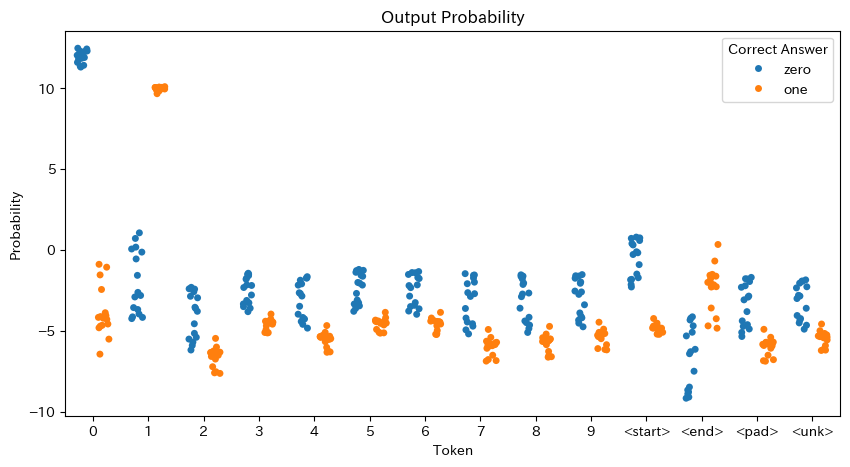

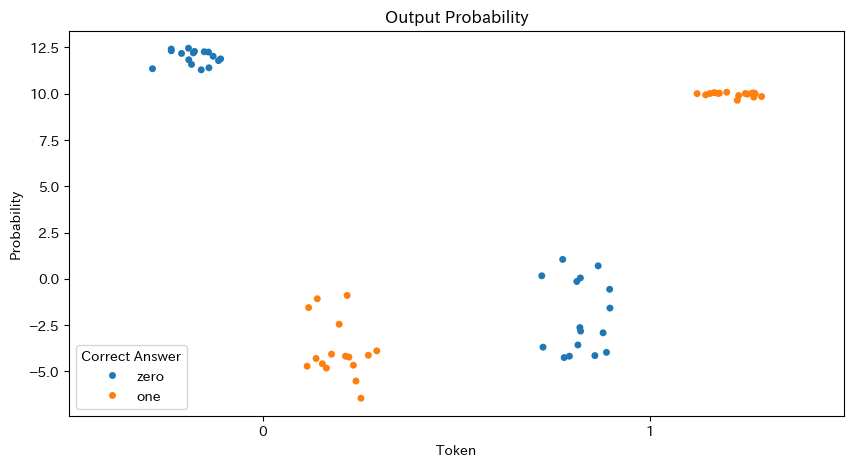

In [62]:
# 結果の出力を取得
def extract_vectors(data_src, model=loaded_model, embedding_size=embedding_size):
    vectors = []
    for src in data_src:
        src = src.view(-1, 1)  # Reshape to (seq_len, batch_size)
        
        memory = model.positional_encoding(model.token_embedding(src))
        memory, _, _ = model.self_attn_encoder(memory, embedding_size)
        memory = model.encoder_layer.norm1(memory)

        tgt = ys
        for _ in range(nth_token-1):
            next_token, _, _ = loaded_model.predict_next_token(src, tgt, embedding_size=embedding_size)
            tgt = torch.cat([tgt, torch.tensor([[next_token]], device=device)], dim=0)
        

        tgt = model.positional_encoding(model.token_embedding(tgt))

        tgt, _, _ = model.self_attn_decoder(tgt, embedding_size)
        tgt = model.decoder_layer.norm1(tgt)

        tgt, _, _ = model.cross_attn(tgt, memory, embedding_size)
        tgt = model.decoder_layer.norm2(tgt)
        output = model.compute_output(tgt.transpose(0, 1)[:, -1])
        vectors.append(output.detach().cpu().numpy().squeeze())
    vectors_array = np.array(vectors)
    return vectors_array

# 偶数と奇数のCross Attention後のベクトルリストを取得
zero_vectors_ca = extract_vectors(zero_src, loaded_model)
one_vectors_ca = extract_vectors(one_src, loaded_model)

plot_stripplot(zero_vectors_ca, one_vectors_ca)
plot_stripplot(zero_vectors_ca[:, :2], one_vectors_ca[:, :2])

(16, 4) (16, 4)


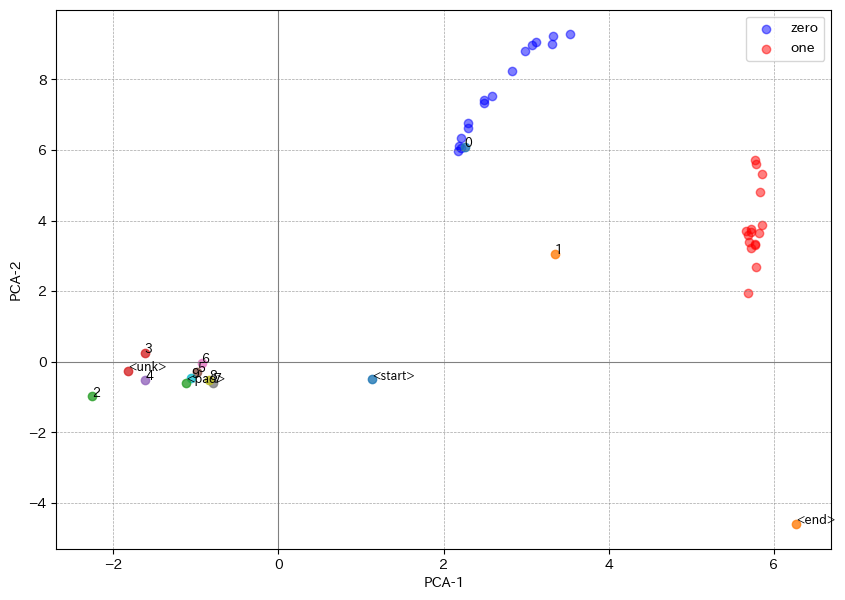

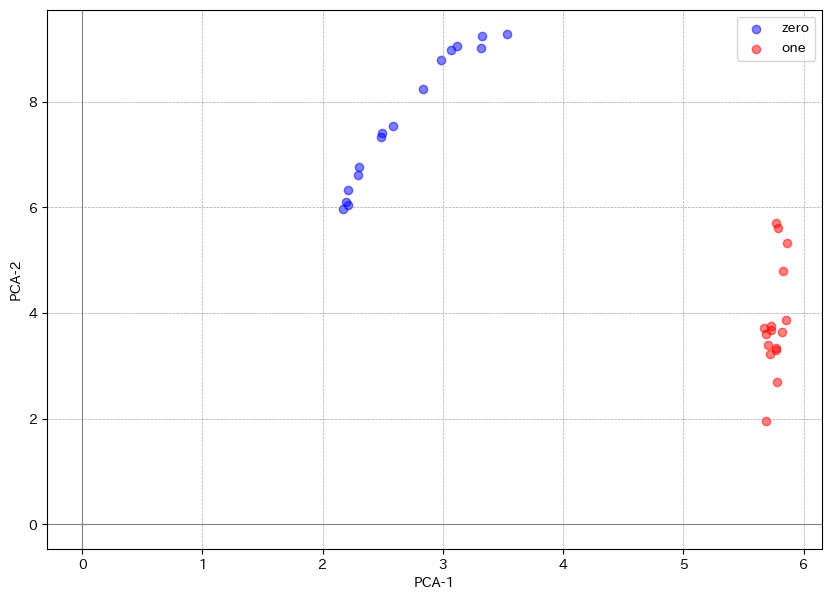

<Figure size 1000x500 with 0 Axes>

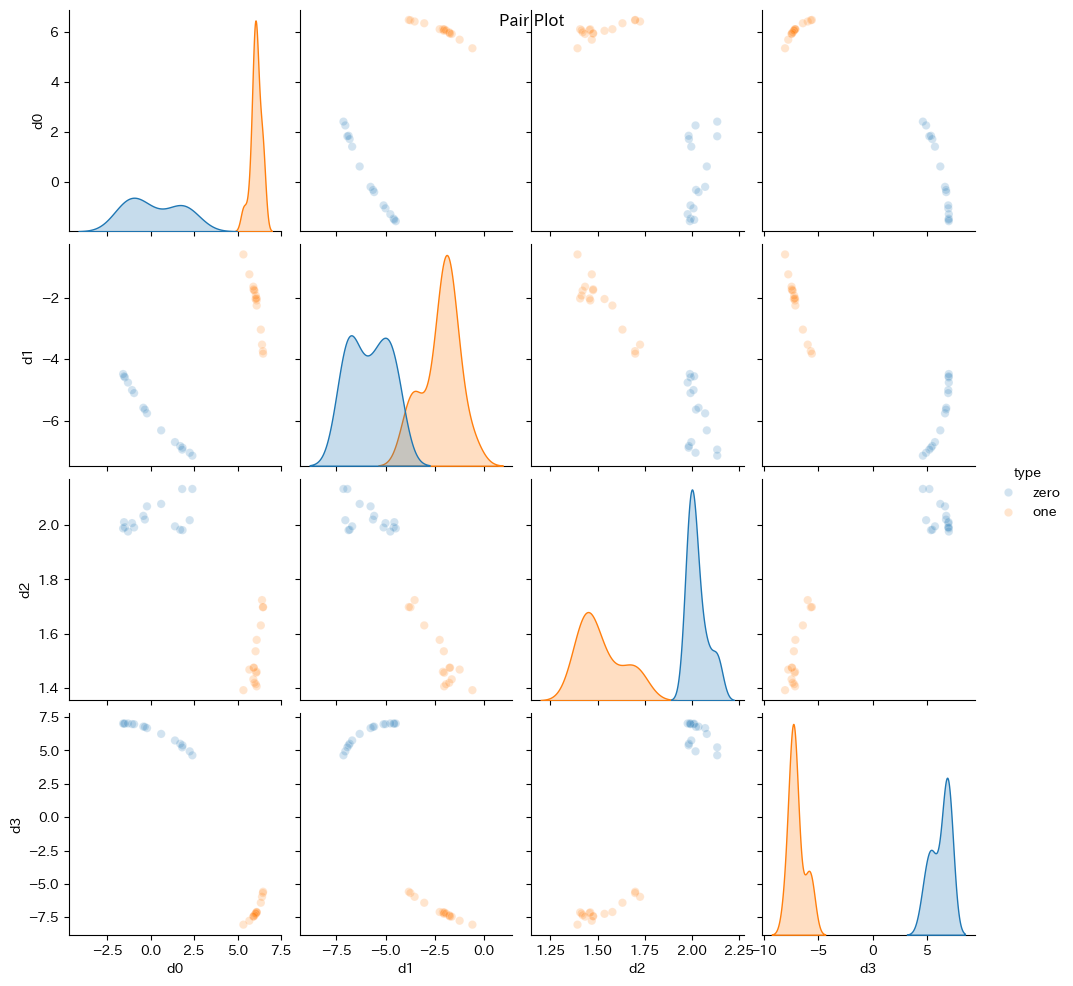

In [63]:
def extract_vectors(data_src, model=loaded_model, embedding_size=embedding_size):
    vectors = []
    for src in data_src:
        src = src.view(-1, 1)  # Reshape to (seq_len, batch_size)
        
        memory = model.positional_encoding(model.token_embedding(src))
        memory, _, _ = model.self_attn_encoder(memory, embedding_size)
        memory = model.encoder_layer.norm1(memory)

        tgt = ys
        for _ in range(nth_token-1):
            next_token, _, _ = loaded_model.predict_next_token(src, tgt, embedding_size=embedding_size)
            tgt = torch.cat([tgt, torch.tensor([[next_token]], device=device)], dim=0)
        

        tgt = model.positional_encoding(model.token_embedding(tgt))

        tgt, _, _ = model.self_attn_decoder(tgt, embedding_size)
        tgt = model.decoder_layer.norm1(tgt)

        tgt, _, _ = model.cross_attn(tgt, memory, embedding_size)
        tgt = model.decoder_layer.norm2(tgt)
        vectors.append(tgt.detach().cpu().numpy().squeeze())
    vectors_array = np.array(vectors)
    return vectors_array

# 偶数と奇数のCross Attention後のベクトルリストを取得
zero_vectors_ca = extract_vectors(zero_src, loaded_model)[:, -1, :]
one_vectors_ca = extract_vectors(one_src, loaded_model)[:, -1, :]
print(zero_vectors_ca.shape, one_vectors_ca.shape)
plot_pca_zero_one(zero_vectors_ca, one_vectors_ca, withEnv=True)
plot_pca_zero_one(zero_vectors_ca, one_vectors_ca, withEnv=False)
plot_pairplot(zero_vectors_ca, one_vectors_ca)

(16, 4) (16, 4)


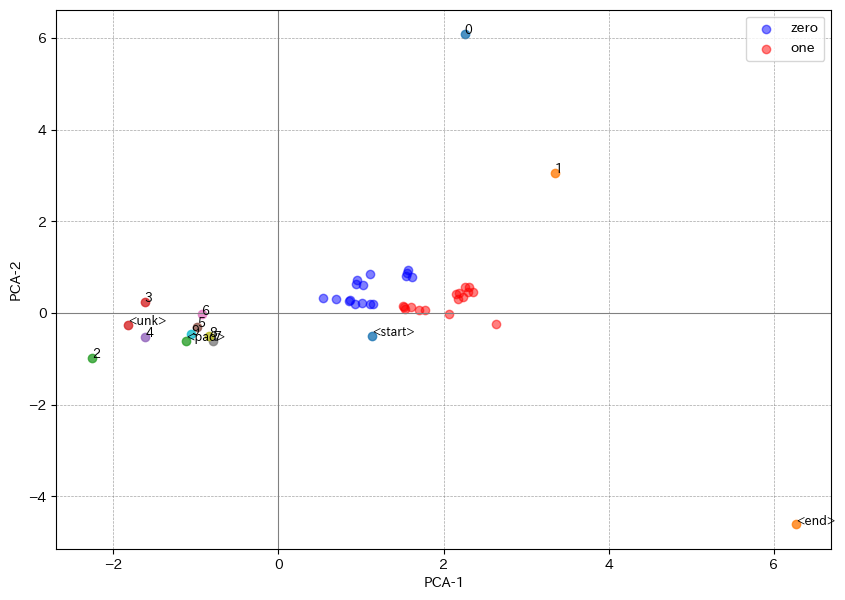

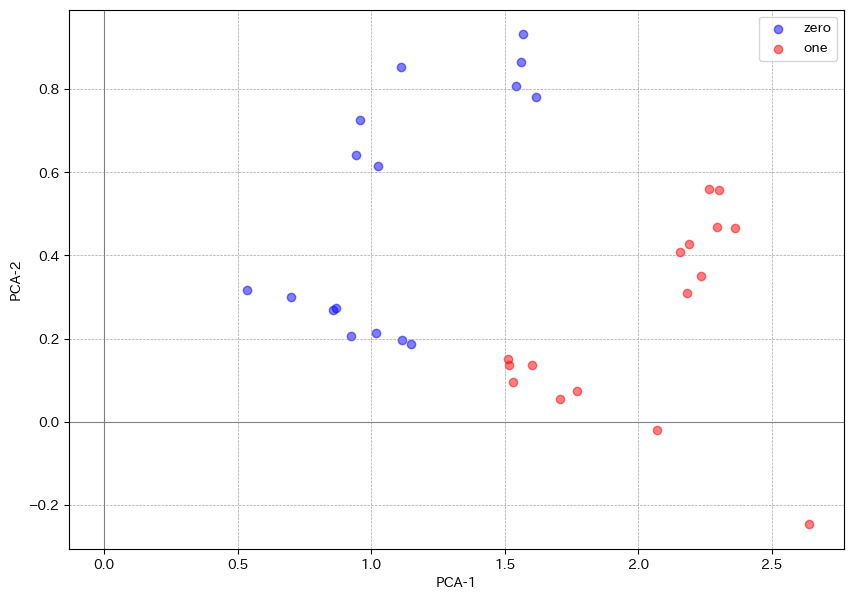

<Figure size 1000x500 with 0 Axes>

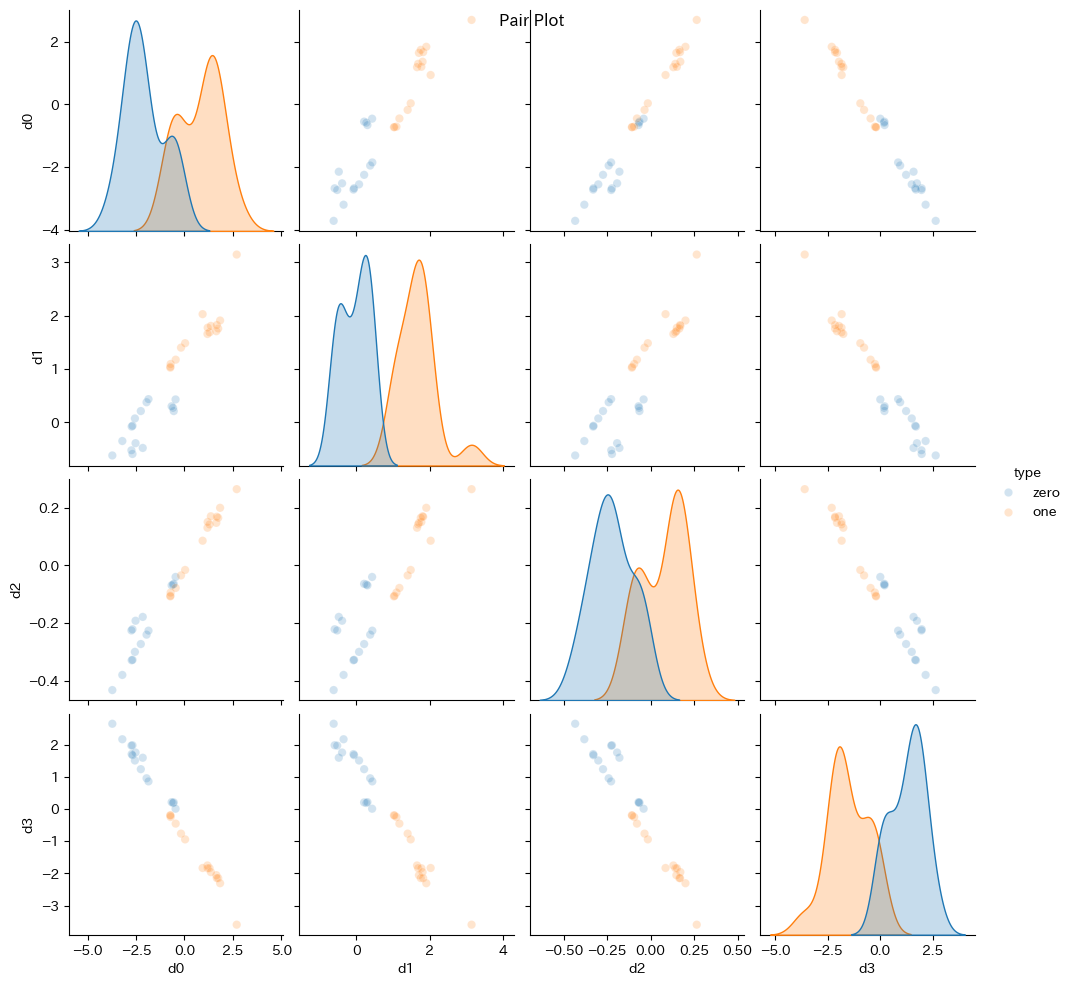

In [64]:
def extract_vectors(data_src, model=loaded_model, embedding_size=embedding_size):
    vectors = []
    for src in data_src:
        src = src.view(-1, 1)  # Reshape to (seq_len, batch_size)
        
        memory = model.positional_encoding(model.token_embedding(src))
        memory, _, _ = model.self_attn_encoder(memory, embedding_size)
        memory = model.encoder_layer.norm1(memory)

        tgt = ys
        for _ in range(nth_token-1):
            next_token, _, _ = loaded_model.predict_next_token(src, tgt, embedding_size=embedding_size)
            tgt = torch.cat([tgt, torch.tensor([[next_token]], device=device)], dim=0)
        

        tgt = model.positional_encoding(model.token_embedding(tgt))

        tgt, _, _ = model.self_attn_decoder(tgt, embedding_size)
        tgt = model.decoder_layer.norm1(tgt)

        tgt, tgt_, _ = model.cross_attn(tgt, memory, embedding_size)
        # tgt_ = model.decoder_layer.norm2(tgt_)
        vectors.append(tgt_[-1, :].detach().cpu().numpy().squeeze())
    vectors_array = np.array(vectors)
    return vectors_array

# 偶数と奇数のCross Attention後のベクトルリストを取得
zero_vectors_ca = extract_vectors(zero_src, loaded_model)
one_vectors_ca = extract_vectors(one_src, loaded_model)
print(zero_vectors_ca.shape, one_vectors_ca.shape)
plot_pca_zero_one(zero_vectors_ca, one_vectors_ca, withEnv=True)
plot_pca_zero_one(zero_vectors_ca, one_vectors_ca, withEnv=False)
plot_pairplot(zero_vectors_ca, one_vectors_ca)


(16, 4, 4) (16, 4, 4)


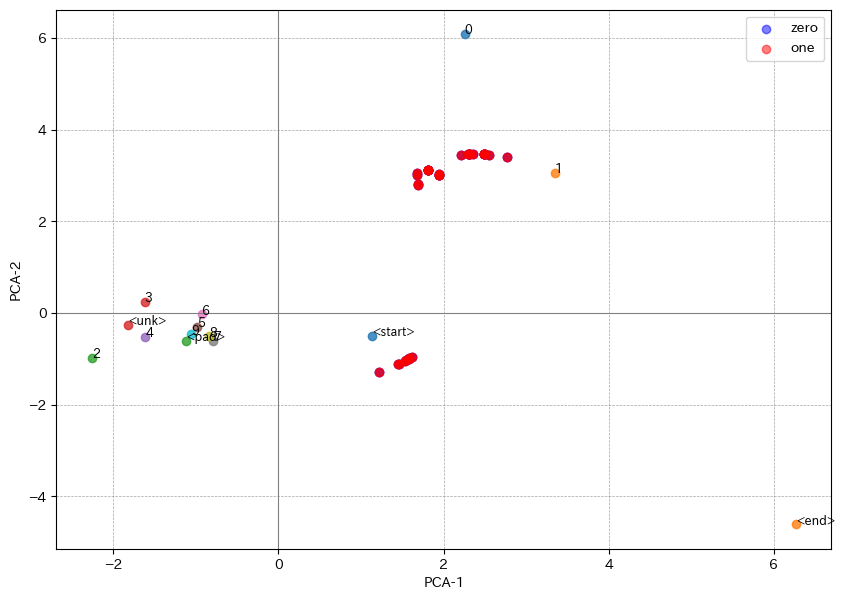

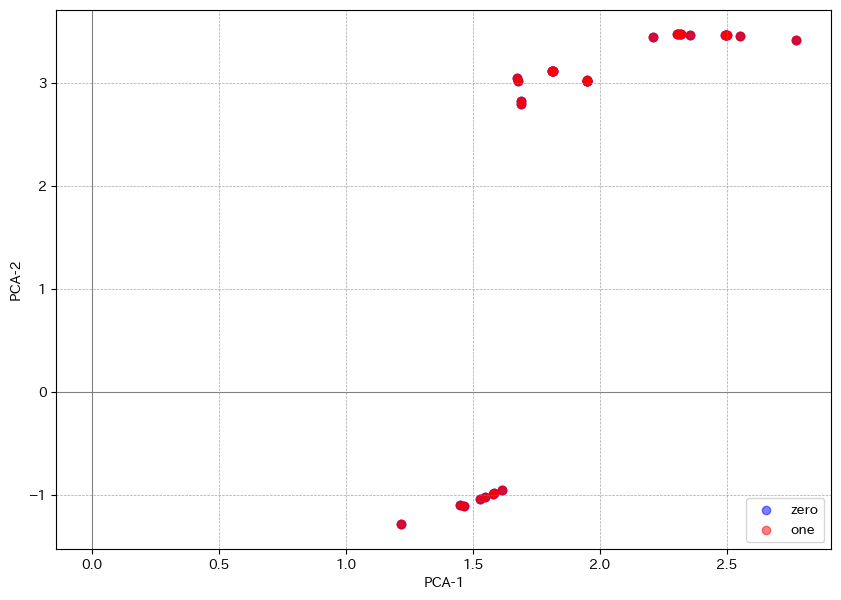

<Figure size 1000x500 with 0 Axes>

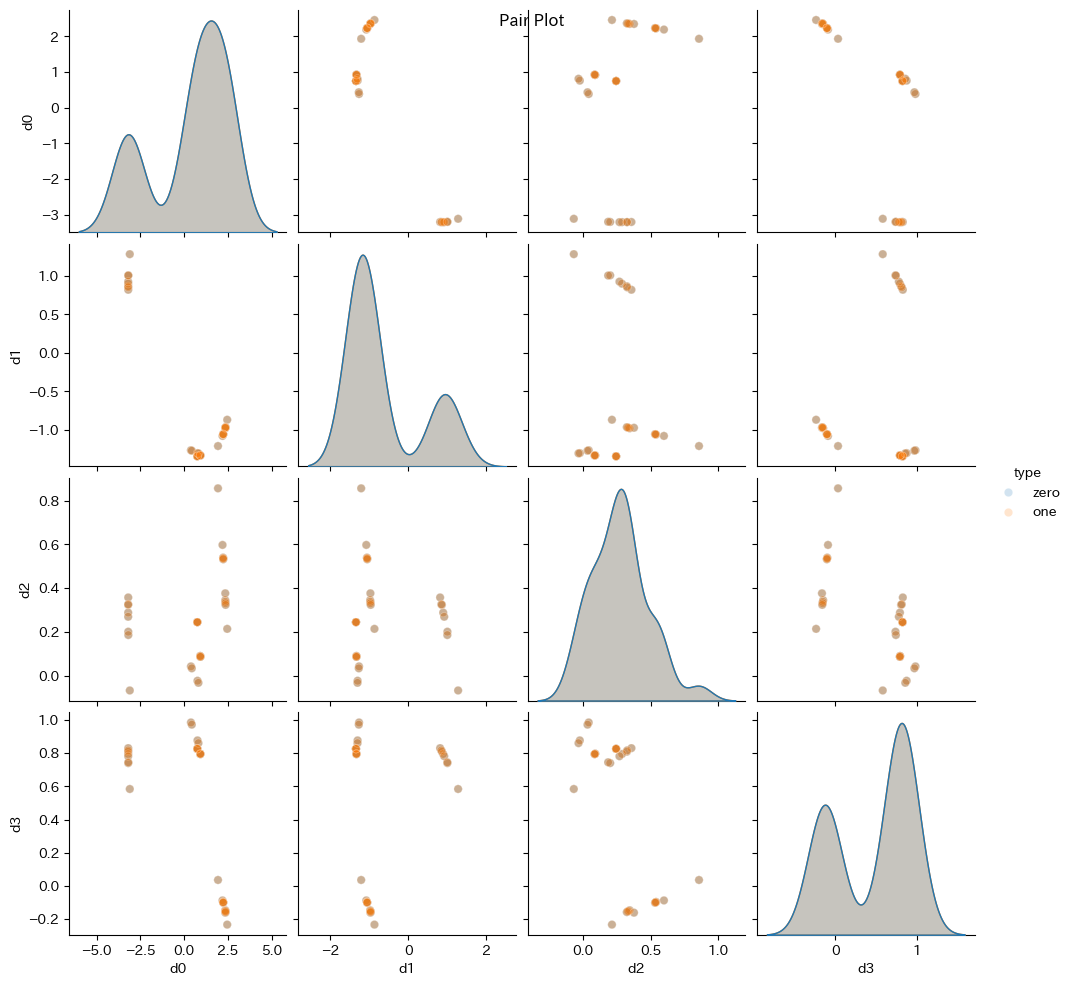

In [52]:
def extract_vectors(data_src, model=loaded_model, embedding_size=embedding_size):
    vectors = []
    for src in data_src:
        src = src.view(-1, 1)  # Reshape to (seq_len, batch_size)
        
        memory = model.positional_encoding(model.token_embedding(src))
        memory, _, _ = model.self_attn_encoder(memory, embedding_size)
        memory = model.encoder_layer.norm1(memory)

        tgt = ys
        for _ in range(nth_token-1):
            next_token, _, _ = loaded_model.predict_next_token(src, tgt, embedding_size=embedding_size)
            tgt = torch.cat([tgt, torch.tensor([[next_token]], device=device)], dim=0)
        

        tgt = model.positional_encoding(model.token_embedding(tgt))

        tgt, _, _ = model.self_attn_decoder(tgt, embedding_size)
        tgt = model.decoder_layer.norm1(tgt)

        vectors.append(tgt.detach().cpu().numpy().squeeze())
    vectors_array = np.array(vectors)
    return vectors_array

# 偶数と奇数のCross Attention後のベクトルリストを取得
zero_vectors_ca = extract_vectors(zero_src, loaded_model)
one_vectors_ca = extract_vectors(one_src, loaded_model)
print(zero_vectors_ca.shape, one_vectors_ca.shape)


# 形状を変換
zero_vectors_ca = zero_vectors_ca.reshape(-1, 4)
one_vectors_ca = one_vectors_ca.reshape(-1, 4)

plot_pca_zero_one(zero_vectors_ca, one_vectors_ca, withEnv=True)
plot_pca_zero_one(zero_vectors_ca, one_vectors_ca, withEnv=False)
plot_pairplot(zero_vectors_ca, one_vectors_ca)


(16, 7, 4) (16, 7, 4)


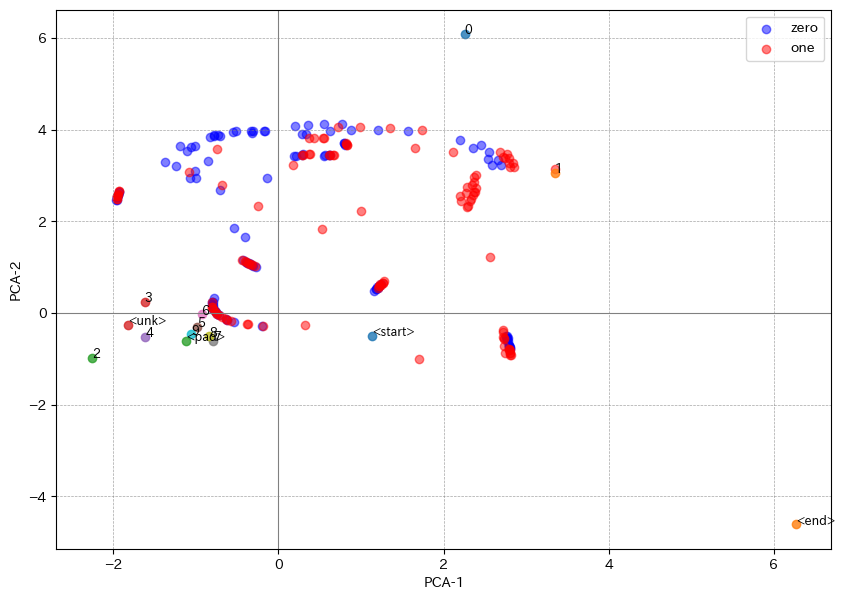

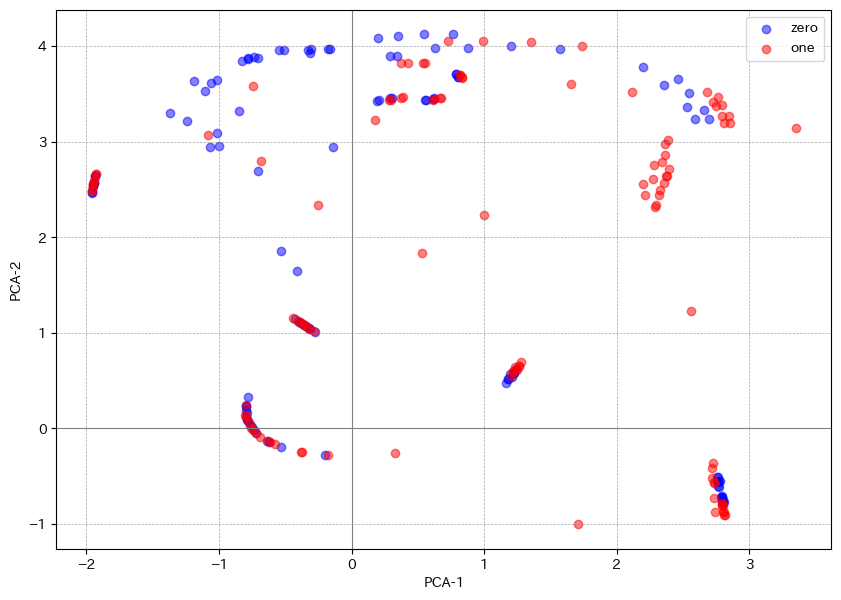

<Figure size 1000x500 with 0 Axes>

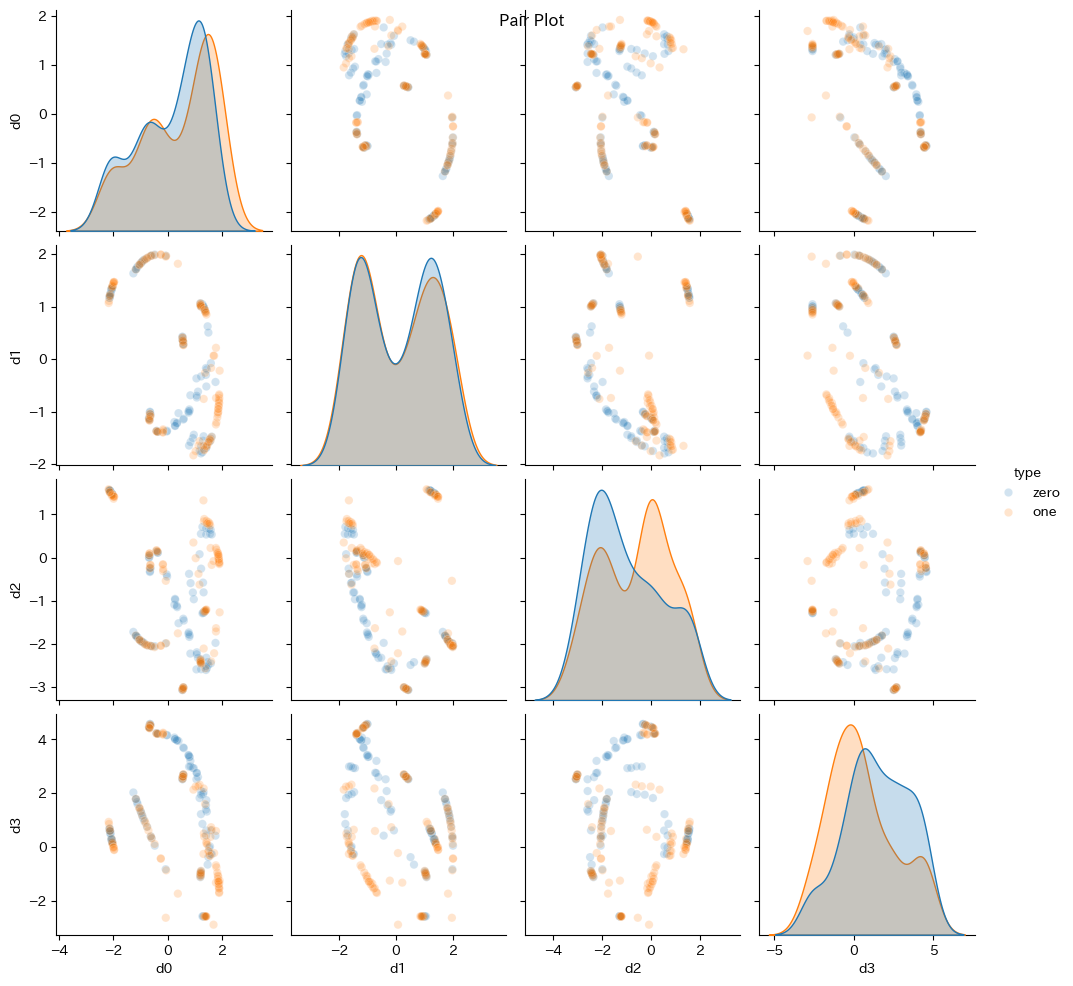

In [53]:
def extract_vectors(data_src, model=loaded_model, embedding_size=embedding_size):
    vectors = []
    for src in data_src:
        src = src.view(-1, 1)  # Reshape to (seq_len, batch_size)
        
        memory = model.positional_encoding(model.token_embedding(src))
        memory, _, _ = model.self_attn_encoder(memory, embedding_size)
        memory = model.encoder_layer.norm1(memory)

        vectors.append(memory[:, :, :].detach().cpu().numpy().squeeze())
    vectors_array = np.array(vectors)
    return vectors_array

# 偶数と奇数のCross Attention後のベクトルリストを取得
zero_vectors_ca = extract_vectors(zero_src, loaded_model)
one_vectors_ca = extract_vectors(one_src, loaded_model)
print(zero_vectors_ca.shape, one_vectors_ca.shape)

# 形状を変換
zero_vectors_ca = zero_vectors_ca.reshape(-1, 4)
one_vectors_ca = one_vectors_ca.reshape(-1, 4)

plot_pca_zero_one(zero_vectors_ca, one_vectors_ca, withEnv=True)
plot_pca_zero_one(zero_vectors_ca, one_vectors_ca, withEnv=False)
plot_pairplot(zero_vectors_ca, one_vectors_ca)

(16, 7, 4) (16, 7, 4)


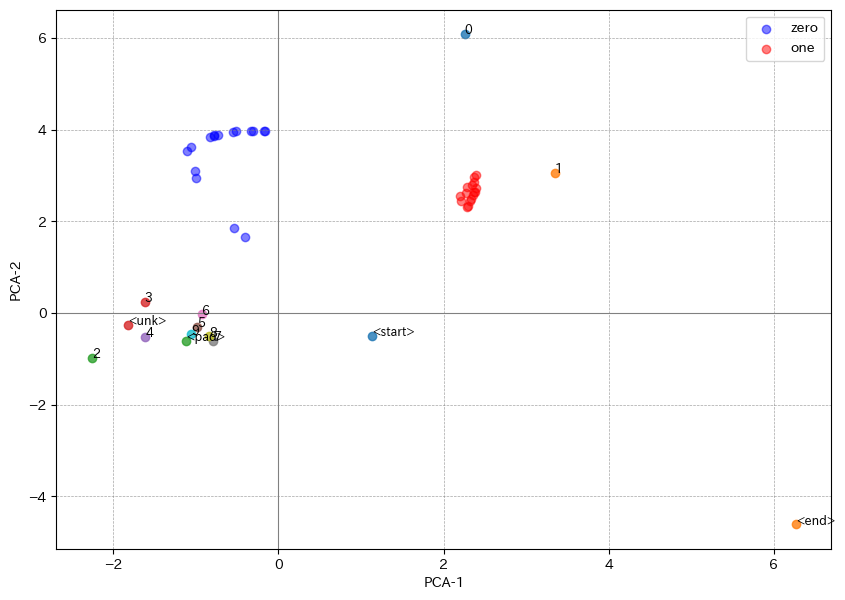

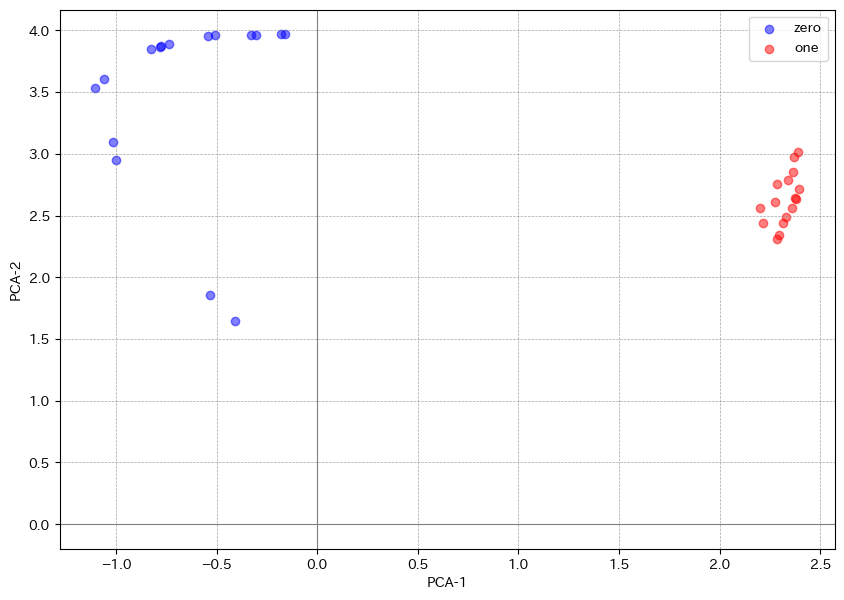

<Figure size 1000x500 with 0 Axes>

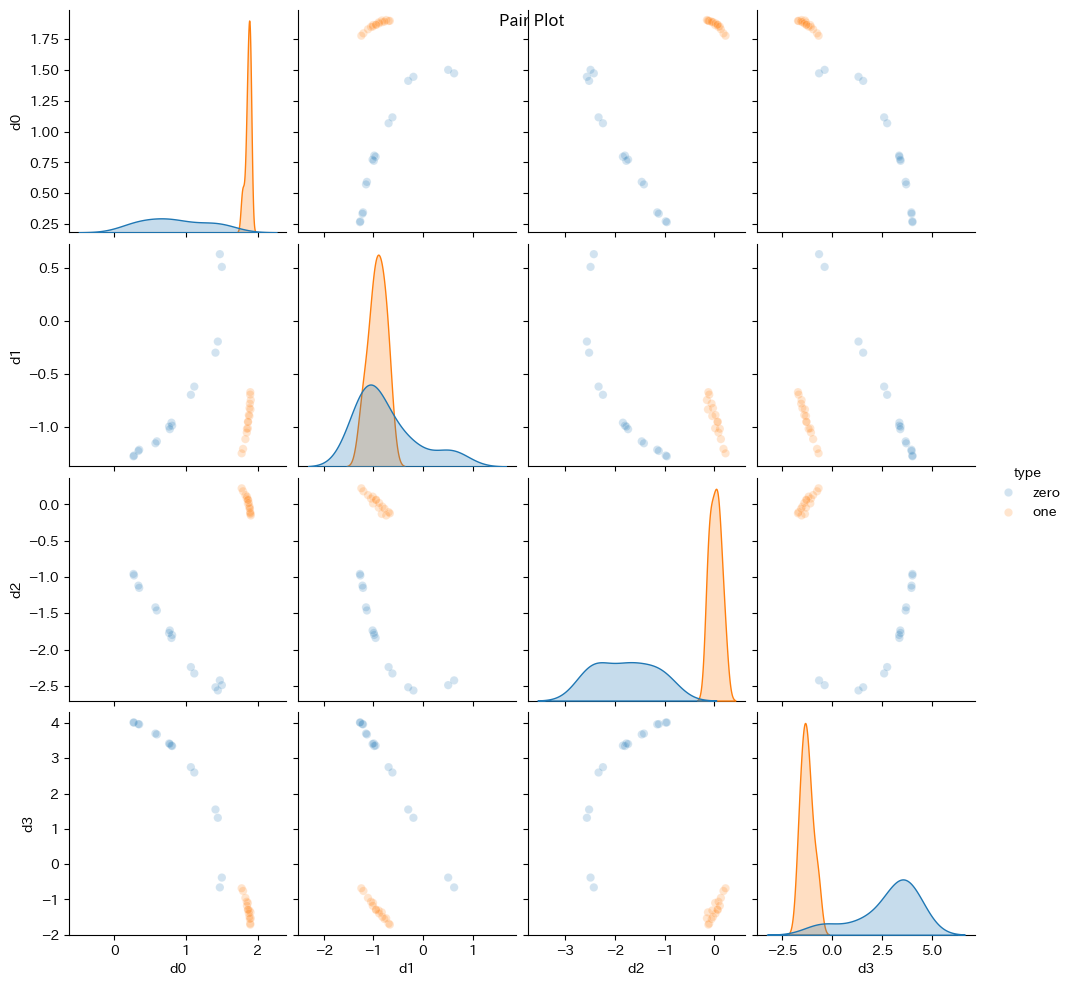

In [56]:
def extract_vectors(data_src, model=loaded_model, embedding_size=embedding_size):
    vectors = []
    for src in data_src:
        src = src.view(-1, 1)  # Reshape to (seq_len, batch_size)
        
        memory = model.positional_encoding(model.token_embedding(src))
        memory, _, _ = model.self_attn_encoder(memory, embedding_size)
        memory = model.encoder_layer.norm1(memory)

        vectors.append(memory[:, :, :].detach().cpu().numpy().squeeze())
    vectors_array = np.array(vectors)
    return vectors_array

# 偶数と奇数のCross Attention後のベクトルリストを取得
zero_vectors_ca = extract_vectors(zero_src, loaded_model)
one_vectors_ca = extract_vectors(one_src, loaded_model)
print(zero_vectors_ca.shape, one_vectors_ca.shape)

# 形状を変換
zero_vectors_ca = zero_vectors_ca[:, -nth_token-1, :]
one_vectors_ca = one_vectors_ca[:, -nth_token-1, :]


plot_pca_zero_one(zero_vectors_ca, one_vectors_ca, withEnv=True)
plot_pca_zero_one(zero_vectors_ca, one_vectors_ca, withEnv=False)
plot_pairplot(zero_vectors_ca, one_vectors_ca)

(16, 7, 4) (16, 7, 4)


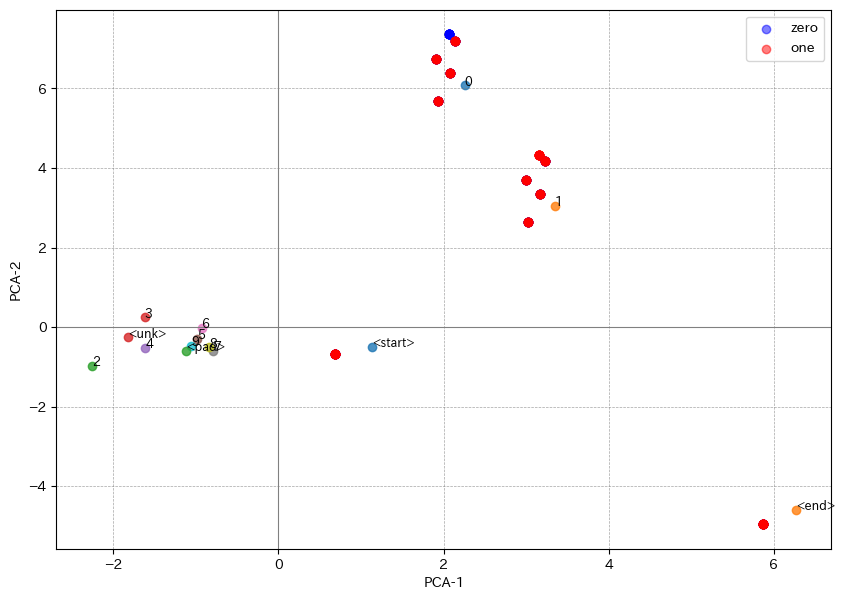

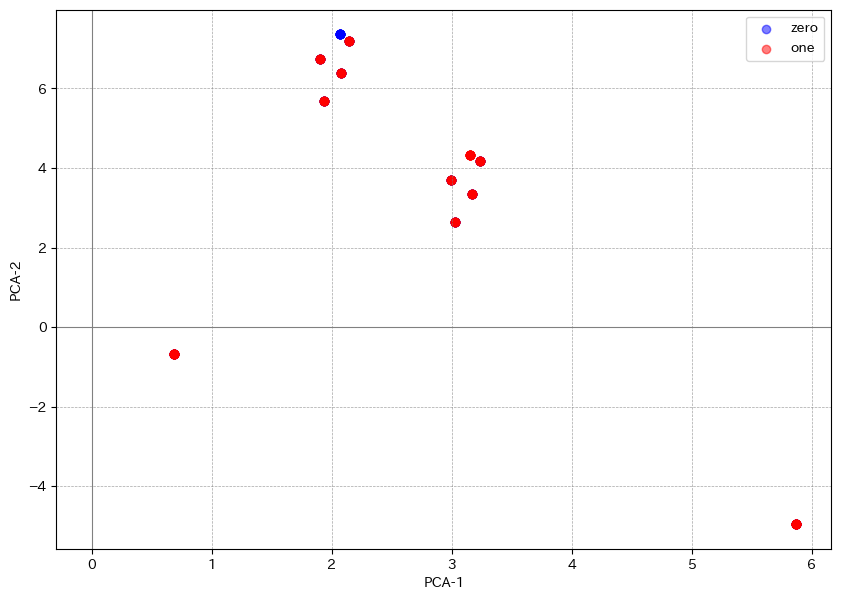

<Figure size 1000x500 with 0 Axes>

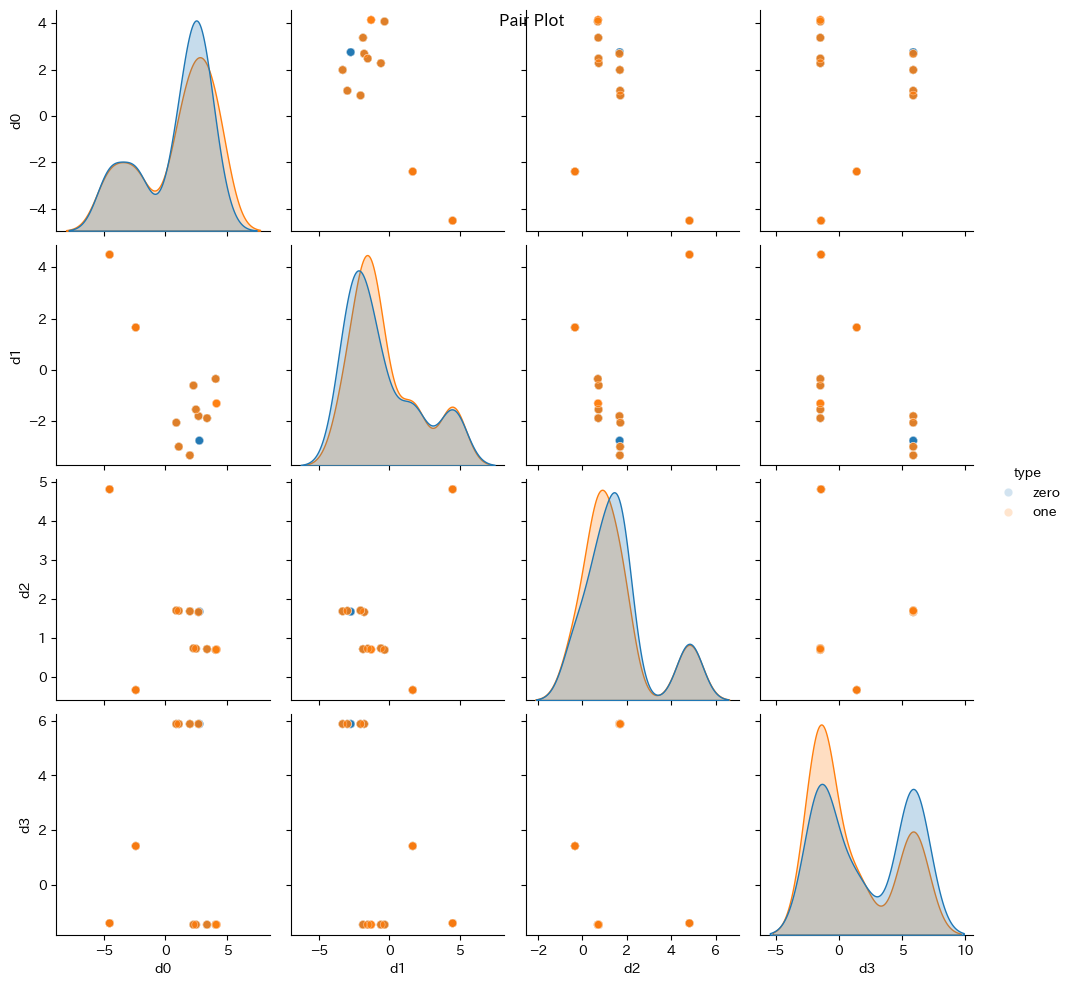

In [55]:
def extract_vectors(data_src, model=loaded_model, embedding_size=embedding_size):
    vectors = []
    for src in data_src:
        src = src.view(-1, 1)  # Reshape to (seq_len, batch_size)
        
        memory = model.positional_encoding(model.token_embedding(src))

        vectors.append(memory[:, :, :].detach().cpu().numpy().squeeze())
    vectors_array = np.array(vectors)
    return vectors_array

# 偶数と奇数のCross Attention後のベクトルリストを取得
zero_vectors_ca = extract_vectors(zero_src, loaded_model)
one_vectors_ca = extract_vectors(one_src, loaded_model)
print(zero_vectors_ca.shape, one_vectors_ca.shape)


# 形状を変換
zero_vectors_ca = zero_vectors_ca.reshape(-1, 4)
one_vectors_ca = one_vectors_ca.reshape(-1, 4)

plot_pca_zero_one(zero_vectors_ca, one_vectors_ca, withEnv=True)
plot_pca_zero_one(zero_vectors_ca, one_vectors_ca, withEnv=False)
plot_pairplot(zero_vectors_ca, one_vectors_ca)
